### Basic ResNet implementation on Pets
* Load and visualize data
* Build multi layer CNN
* Build ResNet

In [33]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

In [4]:
tfms = get_transforms()

In [5]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [6]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [7]:
data = get_data(224, bs)

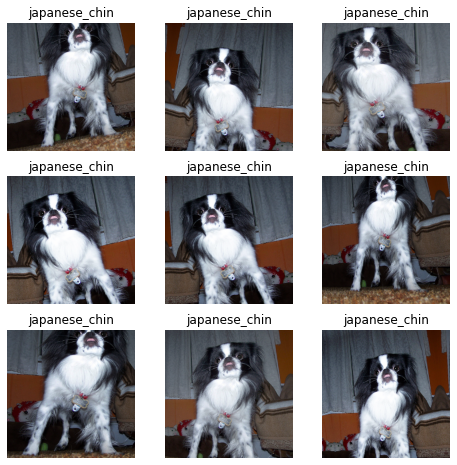

In [8]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [8]:
data.c

37

In [9]:
#learn.destroy()
gc.collect()

82

### Basic sequential model

In [23]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, stride = 2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride = 2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, stride = 2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 256, 3, stride = 2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 512, 3, stride = 2, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, 3, stride = 2, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 256, 3, stride = 2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 37, 3, stride = 2, padding=1),
    nn.BatchNorm2d(37),
    nn.Flatten()
)

In [24]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=error_rate)

In [25]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 112, 112]       896        True      
______________________________________________________________________
BatchNorm2d          [32, 112, 112]       64         True      
______________________________________________________________________
ReLU                 [32, 112, 112]       0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         18,496     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [128, 28, 28]        73,856     True      
___________________________________________________

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


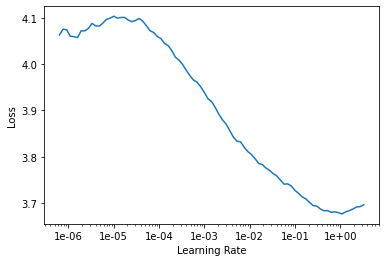

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(100, max_lr = 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.421654,3.189238,0.868065,00:08
1,3.146954,3.025187,0.833559,00:09
2,2.998299,2.911289,0.809202,00:09
3,2.907309,2.857448,0.789581,00:09
4,2.818806,2.786231,0.755751,00:09
5,2.754925,2.695664,0.726658,00:08
6,2.705681,2.656388,0.723275,00:08
7,2.622604,2.877265,0.772666,00:08
8,2.542857,2.553566,0.707037,00:08
9,2.504249,2.564405,0.711773,00:08


In [29]:
learn.save('myconvonly-100')

### ResBlock basic implementation

In [10]:
learn.destroy()
gc.collect()

NameError: name 'learn' is not defined

In [11]:
def seq_conv_bn_relu(ni, no, s=2):
    return nn.Sequential(
        conv2d(ni, no, stride=s),
        batchnorm_2d(no),
        relu()
    )

In [12]:
class ResBlock_same(nn.Module):
    def __init__(self, nf, s=1):
        super().__init__()
        self.conv1 = seq_conv_bn_relu(nf, nf, s)
        self.conv2 = seq_conv_bn_relu(nf, nf, s)
        
    def forward(self, xi):
        x = self.conv1(xi)
        x = self.conv2(x)
        x = xi + x
        return x

In [18]:
ResBlock_same(16)

ResBlock_same(
  (conv1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [13]:
def conv_res(ni, nf, stride=2):
    return nn.Sequential(
        conv2d(ni, nf, stride = stride),
        ResBlock_same(nf)
    )

In [58]:
conv_res(16, 32)

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): ResBlock_same(
    (conv1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
)

In [59]:
class BasicResNet(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.res1 = conv_res(ni, 16)
        self.res2 = conv_res(16, 32)
        self.res3 = conv_res(32, 64)
        self.res4 = conv_res(64, 128)
        self.res5 = conv_res(128, 256)
        self.res6 = conv_res(256, 512)
        self.res7 = conv_res(512, 256)
        #self.conv_last = conv2d(256, 37, stride=2)
        self.flat = nn.Flatten()
        self.clin1 = nn.Linear(1024, 512)
        self.cbn1  = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.clin2 = nn.Linear(512, 37)
        self.cbn2  = nn.BatchNorm1d(37)
                
    def forward(self, xb):
        xb = self.res1(xb)
        xb = self.res2(xb)
        xb = self.res3(xb)
        xb = self.res4(xb)
        xb = self.res5(xb)
        xb = self.res6(xb)
        xb = self.res7(xb)
        #xb = self.conv_last(xb)
        xb = self.flat(xb)
        xb = self.clin1(xb)
        xb = self.cbn1(xb)
        xb = self.relu1(xb)
        xb = self.clin2(xb)
        xb = self.cbn2(xb)
        return xb

In [60]:
model = BasicResNet(3, 37)

In [80]:
model

BasicResNet(
  (res1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ResBlock_same(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (res2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ResBlock_same(
      (conv1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()

In [61]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=error_rate)

In [62]:
learn.summary()

BasicResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 112, 112]       432        True      
______________________________________________________________________
Conv2d               [16, 112, 112]       2,304      True      
______________________________________________________________________
BatchNorm2d          [16, 112, 112]       32         True      
______________________________________________________________________
ReLU                 [16, 112, 112]       0          False     
______________________________________________________________________
Conv2d               [16, 112, 112]       2,304      True      
______________________________________________________________________
BatchNorm2d          [16, 112, 112]       32         True      
______________________________________________________________________
ReLU                 [16, 112, 112]       0          False     
__________________________________________________

In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


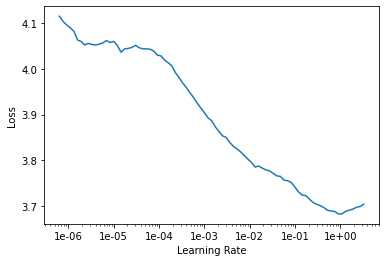

In [64]:
learn.recorder.plot()

In [65]:
learn.fit_one_cycle(100, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.615958,3.472626,0.916103,00:09
1,3.426363,3.308714,0.879567,00:09
2,3.310434,3.231767,0.872124,00:09
3,3.220071,3.168795,0.860622,00:09
4,3.138613,3.078922,0.839648,00:09
5,3.063209,3.028339,0.829499,00:09
6,3.020373,2.988277,0.817321,00:09
7,2.975800,2.950340,0.805819,00:09
8,2.916532,2.930795,0.812585,00:09
9,2.871788,2.884681,0.790257,00:09


### Deeper Resnet

In [14]:
class BasicResNet_d(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.res1 = conv_res(ni, 16)
        self.res11 = conv_res(16, 16, stride=1)
        self.res2 = conv_res(16, 32)
        self.res22 = conv_res(32, 32, stride=1)
        self.res3 = conv_res(32, 64)
        self.res33 = conv_res(64, 64, stride=1)
        self.res4 = conv_res(64, 128)
        self.res44 = conv_res(128, 128, stride=1)
        self.res5 = conv_res(128, 256)
        self.res55 = conv_res(256, 256, stride=1)
        self.res6 = conv_res(256, 512)
        self.res66 = conv_res(512, 512, stride=1)
        self.res7 = conv_res(512, 256)
        self.res77 = conv_res(256, 256, stride=1)
        self.flat = nn.Flatten()
        self.clin1 = nn.Linear(1024, 512)
        self.cbn1  = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.clin2 = nn.Linear(512, 37)
        self.cbn2  = nn.BatchNorm1d(37)
                
    def forward(self, xb):
        xb = self.res1(xb)
        xb = self.res11(xb)
        xb = self.res2(xb)
        xb = self.res22(xb)
        xb = self.res3(xb)
        xb = self.res33(xb)
        xb = self.res4(xb)
        xb = self.res44(xb)
        xb = self.res5(xb)
        xb = self.res55(xb)
        xb = self.res6(xb)
        xb = self.res66(xb)
        xb = self.res7(xb)
        xb = self.res77(xb)
        #xb = self.conv_last(xb)
        xb = self.flat(xb)
        xb = self.clin1(xb)
        xb = self.cbn1(xb)
        xb = self.relu1(xb)
        xb = self.clin2(xb)
        xb = self.cbn2(xb)
        return xb

In [27]:
learn.destroy()
gc.collect()

this object has been destroyed


28

In [15]:
model = model = BasicResNet_d(3, 37)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=error_rate)
learn.summary()

BasicResNet_d
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 112, 112]       432        True      
______________________________________________________________________
Conv2d               [16, 112, 112]       2,304      True      
______________________________________________________________________
BatchNorm2d          [16, 112, 112]       32         True      
______________________________________________________________________
ReLU                 [16, 112, 112]       0          False     
______________________________________________________________________
Conv2d               [16, 112, 112]       2,304      True      
______________________________________________________________________
BatchNorm2d          [16, 112, 112]       32         True      
______________________________________________________________________
ReLU                 [16, 112, 112]       0          False     
________________________________________________

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


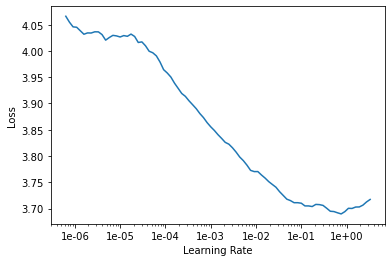

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(100, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.449493,3.271853,0.872801,00:13
1,3.243481,3.137769,0.852503,00:13
2,3.141136,3.089399,0.825440,00:13
3,3.088125,3.076254,0.836942,00:13
4,3.047694,3.133359,0.845061,00:13
5,3.003020,2.897275,0.792963,00:13
6,2.980029,3.096343,0.829499,00:13
7,2.978648,2.976401,0.803112,00:13
8,2.964620,2.992102,0.818674,00:13
9,2.954568,3.145075,0.834912,00:13


In [19]:
learn.save('myresnet-double-100ep')

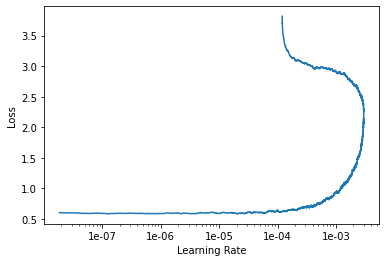

In [20]:
learn.recorder.plot()

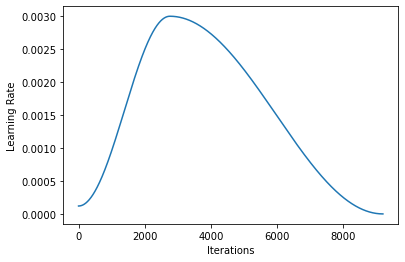

In [21]:
learn.recorder.plot_lr()

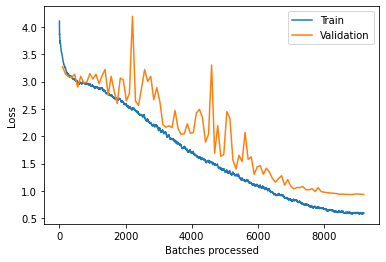

In [22]:
learn.recorder.plot_losses()

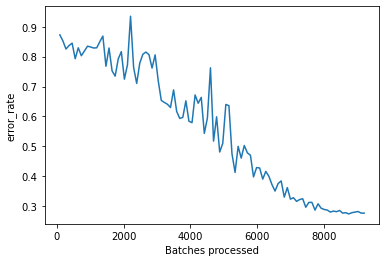

In [23]:
learn.recorder.plot_metrics()

### Real ResNet from scratch

In [38]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [121]:
learn = cnn_learner(data, models.resnet18, loss_func = nn.CrossEntropyLoss(), metrics=error_rate, pretrained=False)

In [40]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


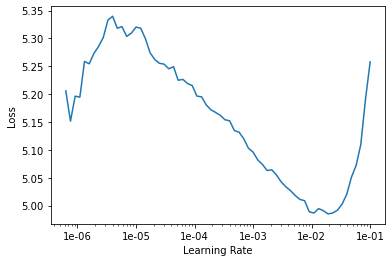

In [47]:
learn.recorder.plot(skip_end=15)

In [48]:
learn.fit_one_cycle(100, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,4.666329,3.680273,0.922192,00:12
1,4.377694,3.506076,0.905954,00:12
2,4.173293,3.314092,0.874154,00:12
3,4.062281,3.349885,0.884303,00:12
4,3.917418,3.262896,0.863329,00:12
5,3.732282,3.185435,0.835589,00:12
6,3.627331,3.499747,0.894452,00:12
7,3.494572,3.398448,0.828823,00:12
8,3.372263,3.085529,0.836942,00:12
9,3.186137,4.106527,0.862652,00:12


In [49]:
learn.save('origresnet18-nopretrain-100')

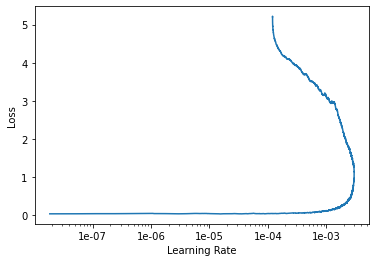

In [50]:
learn.recorder.plot()

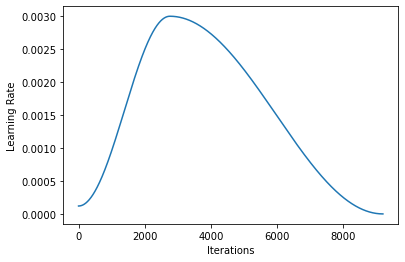

In [51]:
learn.recorder.plot_lr()

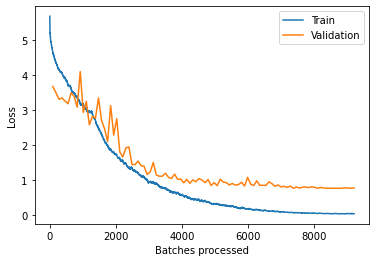

In [52]:
learn.recorder.plot_losses()

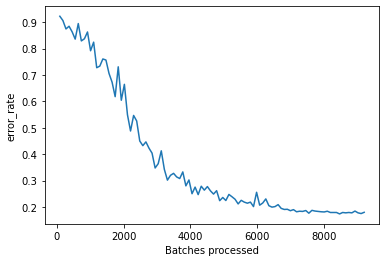

In [53]:
learn.recorder.plot_metrics()

In [117]:
learn.load('origresnet18-nopretrain-100')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Siamese,chihuahua,german_shorthaired,japanese_chin,havanese
Path: /home/CW01/uia94835/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,american_bulldog,Persian,Egyptian_Mau,shiba_inu
Path: /home/CW01/uia94835/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (c

In [118]:
learn.validate()

[0.77079815, tensor(0.1800)]

In [119]:
learn.validate(metrics=[error_rate])

[0.77079815, tensor(0.1800)]

### ResNet from scratch, onecycle start0.5

In [120]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [57]:
learn = cnn_learner(data, models.resnet18, loss_func = nn.CrossEntropyLoss(), metrics=error_rate, pretrained=False)
learn.fit_one_cycle(100, 3e-3, pct_start=0.5)
learn.save('origresnet18-nopretrain-100-pctstart05')

epoch,train_loss,valid_loss,error_rate,time
0,4.608443,3.702787,0.931664,00:12
1,4.427956,3.479216,0.897158,00:12
2,4.231715,3.349008,0.883627,00:12
3,4.101478,3.366292,0.872801,00:13
4,3.962003,3.269730,0.874831,00:12
5,3.781202,3.096478,0.811231,00:12
6,3.649780,3.002574,0.807848,00:12
7,3.515968,3.037997,0.813938,00:12
8,3.364108,3.104363,0.822733,00:12
9,3.187456,2.972368,0.780108,00:12


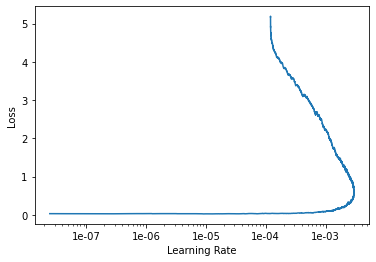

In [58]:
learn.recorder.plot()

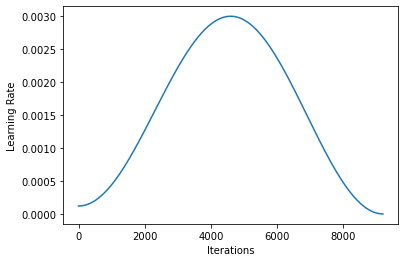

In [59]:
learn.recorder.plot_lr()

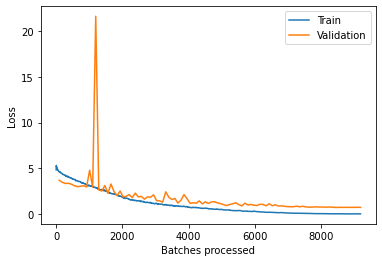

In [60]:
learn.recorder.plot_losses()

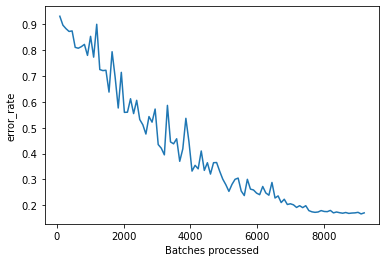

In [61]:
learn.recorder.plot_metrics()

In [123]:
_ = learn.load('origresnet18-nopretrain-100-pctstart05')

In [124]:
learn.validate()

[0.7361181, tensor(0.1705)]

In [125]:
learn.validate(metrics=[error_rate])

[0.7361181, tensor(0.1705)]

### ResNet from scratch, onecycle start0.7

In [62]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [63]:
learn = cnn_learner(data, models.resnet18, loss_func = nn.CrossEntropyLoss(), metrics=error_rate, pretrained=False)
learn.fit_one_cycle(100, 3e-3, pct_start=0.7)
learn.save('origresnet18-nopretrain-100-pctstart07')

epoch,train_loss,valid_loss,error_rate,time
0,4.717509,3.662870,0.931664,00:12
1,4.426508,3.378273,0.894452,00:13
2,4.245128,3.372026,0.894452,00:13
3,4.078466,3.247151,0.850474,00:12
4,3.915785,3.133445,0.843031,00:13
5,3.805120,3.073452,0.824087,00:12
6,3.656092,3.086021,0.797023,00:12
7,3.471730,2.908537,0.784168,00:12
8,3.358540,3.108805,0.797023,00:12
9,3.254295,2.941554,0.761840,00:13


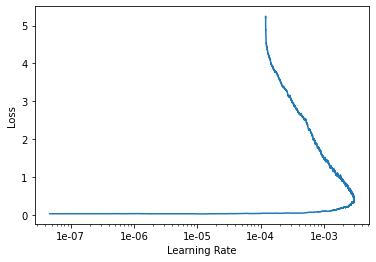

In [64]:
learn.recorder.plot()

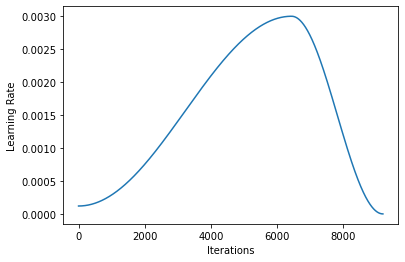

In [65]:
learn.recorder.plot_lr()

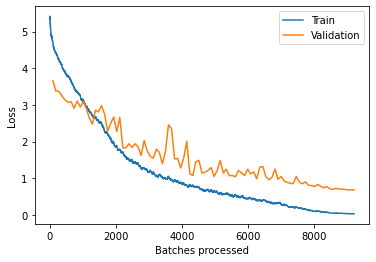

In [66]:
learn.recorder.plot_losses()

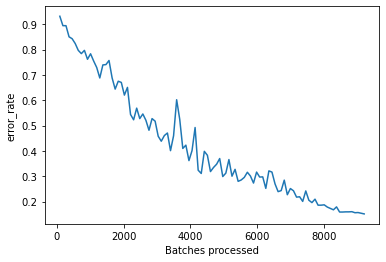

In [67]:
learn.recorder.plot_metrics()

In [126]:
learn.load('origresnet18-nopretrain-100-pctstart07')
learn.validate()

[0.68254155, tensor(0.1516)]

### ResNet from scratch, fit_fc()

In [70]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [71]:
learn = cnn_learner(data, models.resnet18, loss_func = nn.CrossEntropyLoss(), metrics=error_rate, pretrained=False)

In [72]:
learn.fit_fc(100, 3e-3)
learn.save('origresnet18-nopretrain-100-fitfc')

epoch,train_loss,valid_loss,error_rate,time
0,4.236144,3.533973,0.910014,00:13
1,4.054688,4.203207,0.927605,00:13
2,3.767994,5.581509,0.906631,00:13
3,3.647045,18.081017,0.953315,00:13
4,3.563985,3.397753,0.866712,00:13
5,3.440753,3.204550,0.830176,00:13
6,3.393259,3.750139,0.838972,00:13
7,3.288393,3.131383,0.796346,00:13
8,3.134144,3.012615,0.782138,00:13
9,3.070245,3.524056,0.809202,00:13


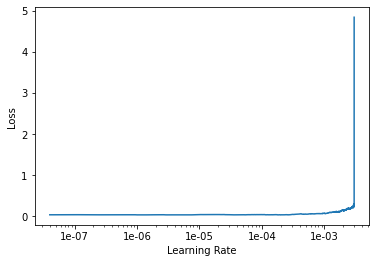

In [73]:
learn.recorder.plot()

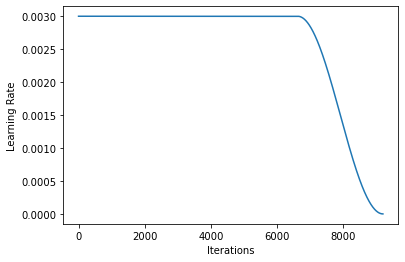

In [74]:
learn.recorder.plot_lr()

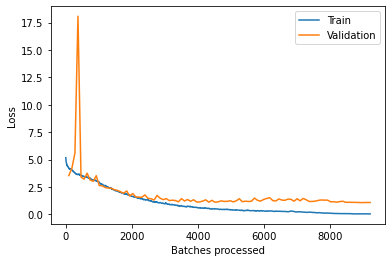

In [75]:
learn.recorder.plot_losses()

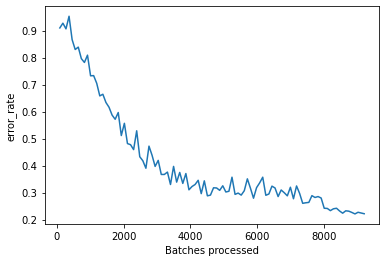

In [76]:
learn.recorder.plot_metrics()

In [127]:
learn.load('origresnet18-nopretrain-100-fitfc')
learn.validate()

[1.0772285, tensor(0.2219)]

### ResNet from scratch, fit()

In [77]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [78]:
learn = cnn_learner(data, models.resnet18, loss_func = nn.CrossEntropyLoss(), metrics=error_rate, pretrained=False)

In [79]:
learn.fit(100, 3e-3)
learn.save('origresnet18-nopretrain-100-fit')

epoch,train_loss,valid_loss,error_rate,time
0,4.346908,3.754436,0.919486,00:13
1,4.022183,3.641117,0.929635,00:13
2,3.751510,3.364394,0.876861,00:13
3,3.615465,15.970454,0.933018,00:13
4,3.542071,3.907544,0.881597,00:13
5,3.406329,4.207120,0.855210,00:13
6,3.350091,4.585138,0.876861,00:13
7,3.203136,3.059820,0.776049,00:13
8,3.092729,8.450308,0.820704,00:13
9,2.947378,2.627124,0.712449,00:13


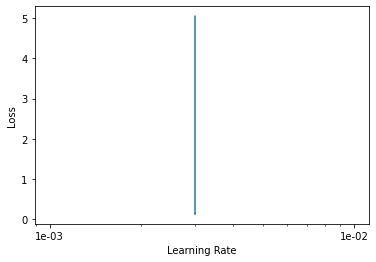

In [80]:
learn.recorder.plot()

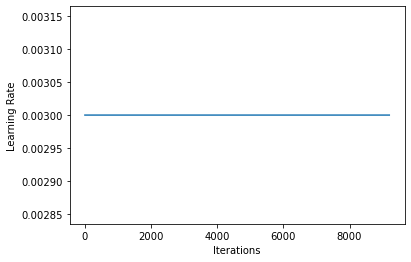

In [81]:
learn.recorder.plot_lr()

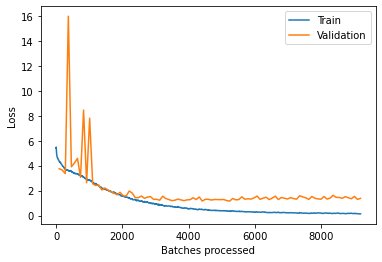

In [82]:
learn.recorder.plot_losses()

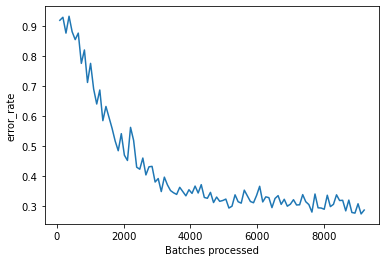

In [83]:
learn.recorder.plot_metrics()

In [128]:
learn.load('origresnet18-nopretrain-100-fit')
learn.validate()

[1.3785876, tensor(0.2876)]

### ResNet from scratch, fit_fc(0.5)

In [84]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [85]:
learn = cnn_learner(data, models.resnet18, loss_func = nn.CrossEntropyLoss(), metrics=error_rate, pretrained=False)

In [86]:
learn.fit_fc(100, 3e-3, start_pct=0.5)
learn.save('origresnet18-nopretrain-100-fitfc05')

epoch,train_loss,valid_loss,error_rate,time
0,4.360338,7.921431,0.960758,00:13
1,4.027560,3.439081,0.930988,00:12
2,3.789013,3.295322,0.893099,00:13
3,3.633911,3.573931,0.933694,00:13
4,3.470839,3.026627,0.832206,00:13
5,3.345932,3.844061,0.845737,00:13
6,3.257978,3.556286,0.874831,00:13
7,3.250571,3.003511,0.819350,00:13
8,3.133923,3.116286,0.817997,00:13
9,2.992159,2.910626,0.740866,00:13


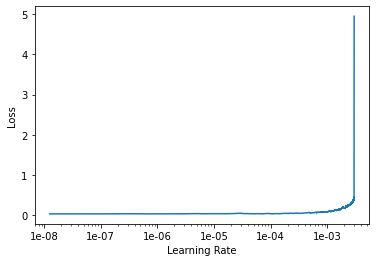

In [87]:
learn.recorder.plot()

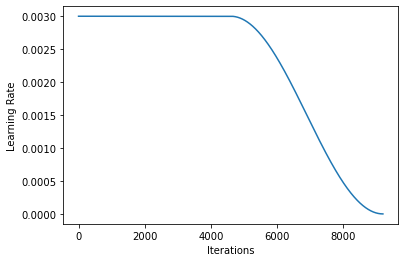

In [88]:
learn.recorder.plot_lr()

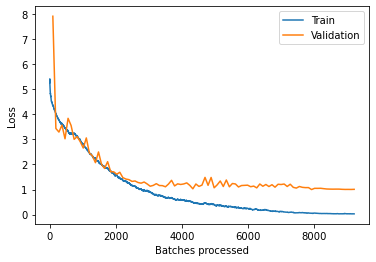

In [89]:
learn.recorder.plot_losses()

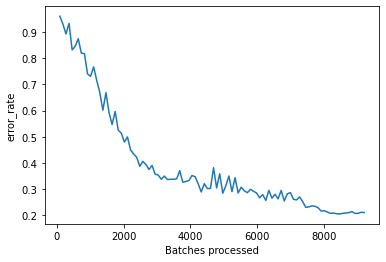

In [90]:
learn.recorder.plot_metrics()

### ResNet from scratch, fit_fc(0.35)

In [96]:
learn.destroy()
gc.collect()

this object has been destroyed


20

In [97]:
learn = cnn_learner(data, models.resnet18, loss_func = nn.CrossEntropyLoss(), metrics=error_rate, pretrained=False)

In [98]:
learn.fit_fc(100, 3e-3, start_pct=0.35)
learn.save('origresnet18-nopretrain-100-fitfc035')

epoch,train_loss,valid_loss,error_rate,time
0,4.310207,3.568855,0.915426,00:13
1,3.964345,3.581907,0.924222,00:12
2,3.702515,4.328686,0.878214,00:13
3,3.567163,3.408242,0.865359,00:13
4,3.501140,3.471304,0.864005,00:13
5,3.317177,2.967970,0.798376,00:13
6,3.261769,4.670565,0.825440,00:13
7,3.152573,2.745166,0.769283,00:12
8,3.050599,2.735015,0.736807,00:13
9,2.931767,2.623893,0.724628,00:13


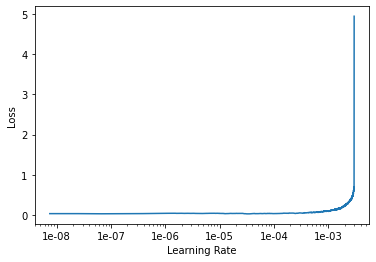

In [99]:
learn.recorder.plot()

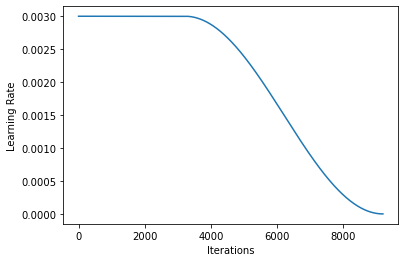

In [100]:
learn.recorder.plot_lr()

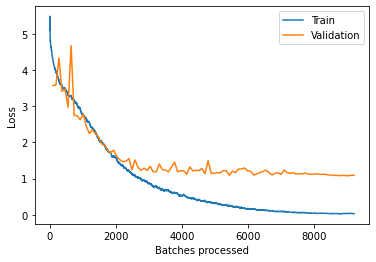

In [101]:
learn.recorder.plot_losses()

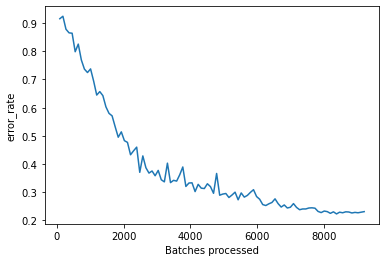

In [102]:
learn.recorder.plot_metrics()

In [110]:
learn.validate()

[1.3524674, tensor(0.2930)]

In [114]:
learn.validate(metrics=[error_rate])

[1.3524674, tensor(0.2930)]